In [1]:
import numpy as np
import tensorflow as tf
import scipy
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import newton
import imp
imp.reload(newton)


tf.keras.backend.set_floatx('float64')

In [2]:
#separate data into training set, validation set, test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

x_val = x_train[0:10000]
y_val = y_train[0:10000]
x_train = x_train[10000:]
y_train = y_train[10000:]

#batch size
bs = 10000

In [3]:
#create linear solver to use in newton iterations
#p = ['dense',1e-12]        #dense linear solver, l2 regularizer
p = ['cg',1e-6,3]           #congugate gradient linear solver, tolerance, max iterations
LS = newton.makeLS(p)

lr=1e-3 #adam learning rate


#dense neural network model
def makemodel(opt):
    NN = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(10,activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax',use_bias=False)
    ])
    nvars = NN.variables[-1]
    if opt == 'ngd':
        gdvars = NN.variables[0:-1]
    elif opt == 'gd':
        gdvars = NN.variables
    gopt=tf.keras.optimizers.Adam(lr)
    
    m = newton.model(NN,nvars,gdvars,gopt,LS)
    return m

In [4]:
#trains model with newton-gd
ngd = makemodel('ngd')
ngd_Js=[]
ngd_accs = []
for epochs in range(10):
    for b in range(len(x_train)//bs):
        x = x_train[b*bs:(b+1)*bs]
        ytrue = y_train[b*bs:(b+1)*bs]
    
        for i in range(5):
            ngd.newton(x,ytrue)

        ngd_Js.append(ngd.getJ(x,ytrue).numpy())
        ngd_accs.append(ngd.getacc(x_val,y_val))

        ngd.gd(x,ytrue)
        ngd_Js.append(ngd.getJ(x,ytrue).numpy())
        ngd_accs.append(ngd.getacc(x_val,y_val))

print('Newton+GD test accuracy: ',ngd.getacc(x_test,y_test))





#trains model with gd
gd = makemodel('gd')
gd_Js=[]
gd_accs = []
for epochs in range(20):
    for b in range(len(x_train)//bs):
        x = x_train[b*bs:(b+1)*bs]
        ytrue = y_train[b*bs:(b+1)*bs]

        gd.gd(x,ytrue)
        gd_Js.append(gd.getJ(x,ytrue).numpy())
        gd_accs.append(gd.getacc(x_val,y_val))

print('GD test accuracy: ',gd.getacc(x_test,y_test))

Newton+GD test accuracy:  0.9388
GD test accuracy:  0.9159


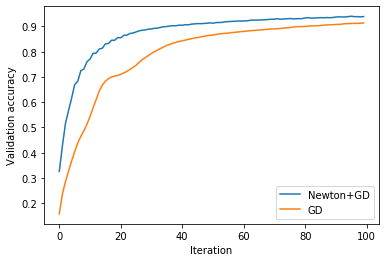

In [5]:
plt.plot(ngd_accs,label="Newton+GD")
plt.plot(gd_accs,label="GD")
plt.xlabel("Iteration")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()